In [538]:
#IMPORTING SHIT
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt


import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from scipy.signal import lfilter

from os.path import dirname, join as pjoin


import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

import wave

import colorednoise as cn
#from matplotlib import pylab as plt

import sounddevice as sd

from tqdm import tqdm
import time

import pathlib
from util.util import load_data_json, to_db
from expr.analysis import load_analysis

import hr.pam as pam
import hr.process as pierre

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> ## Signal Synthesis

> Simple Noisless Signal with Two Sinusoids

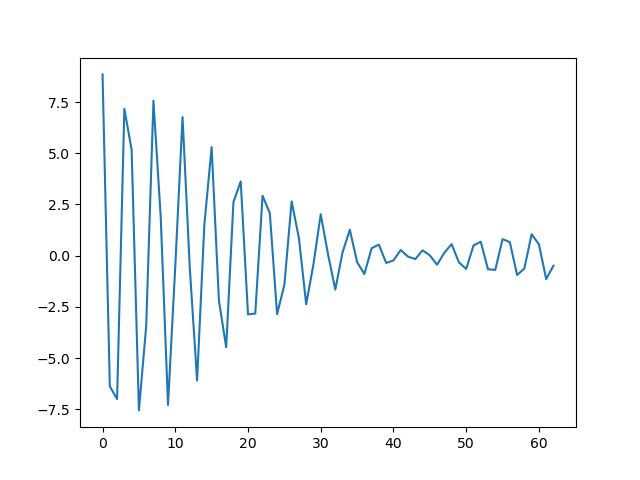

In [342]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = pam.synthesize(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x_synth[0]))

#np.max(np.real(x_synth))

> Simple Noisless Signal with One Sinusoid and Vibrato Effect

In [343]:
N_vibr0 = 2**9-1

delta_vibr0 = np.array([0])

f_vibr0 = np.array([0.3])

a_vibr0 = np.array([2])

phi_vibr0 = np.array([0])

vibrato0 = pam.synthesize(N_vibr0, delta_vibr0, f_vibr0, a_vibr0, phi_vibr0, 0.02, 5, 0, 0)

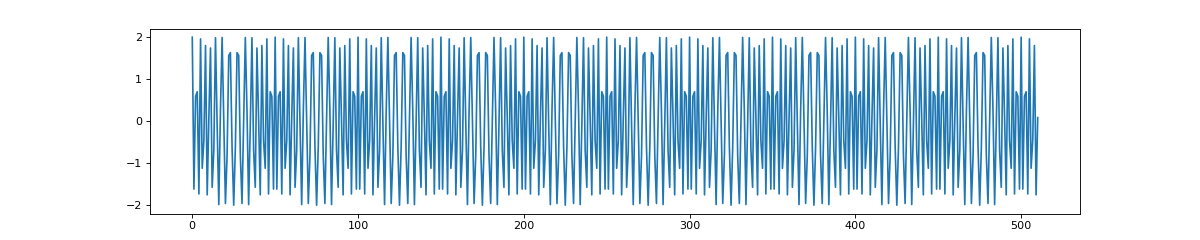

In [344]:
plt.figure(figsize=(15, 3), dpi=80)

plt.plot(np.real(vibrato0[0]))
plt.show()


In [345]:
fs_vibr0 = 1000

sd.play(np.real(vibrato0[0]), fs_vibr0)

print("The length of the signal is", N_vibr0/fs_vibr0, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr0, fs_vibr0)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato0[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr0, data.astype(np.int16))

The length of the signal is 0.511 seconds.


> Noisless Signal with Eight Sinusoids and vibrato Effect

In [346]:
N_vibr1 = 2**11-1

K_vibr1 = 8

f0_vibr1 = 0.06
f_vibr1 = f0_vibr1*np.arange(1,K_vibr1+1)

a_vibr1 = np.array([0.00807193, 0.09748246, 0.02404544, 0.04275309, 0.02482811,
       0.08778044, 0.00470351, 0.03118916])

delta_vibr1 = -0.0001*np.random.rand(K_vibr1)

phi_vibr1 = np.array([1.76348603, 1.20411769, 0.76158339, 1.35157899, 0.36247392,
       1.44086579, 1.73647764, 1.98131046])

vibrato1 = pam.synthesize(N_vibr1, delta_vibr1, f_vibr1, a_vibr1, phi_vibr1, 0.003, 10, 0, 0)

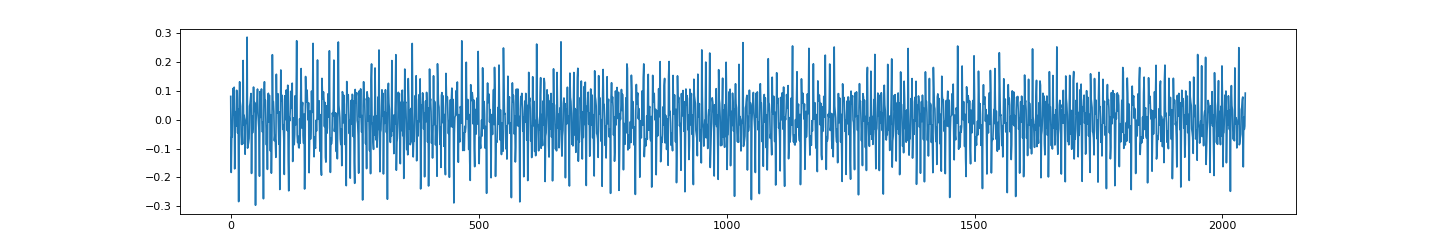

In [347]:
plt.figure(figsize=(18, 3), dpi=80)

plt.plot(np.real(vibrato1[0]))

plt.show()

In [348]:
fs_vibr1 = 1000

sd.play(np.real(vibrato1[0]), fs_vibr1)

print("The length of the signal is", N_vibr1/fs_vibr1, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr1, fs_vibr1)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato1[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr1, data.astype(np.int16))

The length of the signal is 2.047 seconds.


> Noisless Signal with Eight Sinusoids (Pink Noise and SNR = 39 dB)

SNR = 38.65382560968904 dB


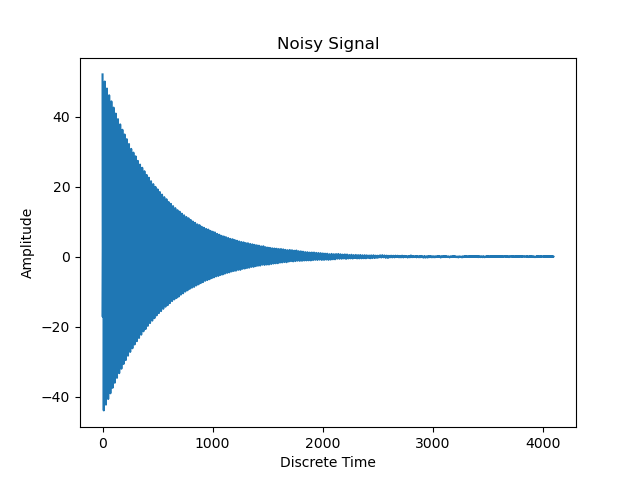

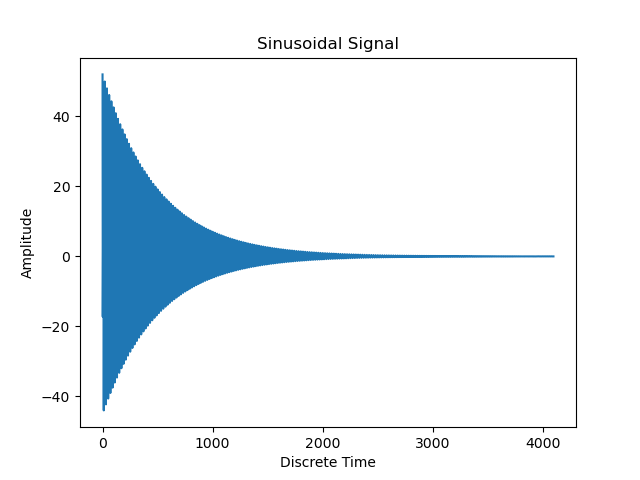

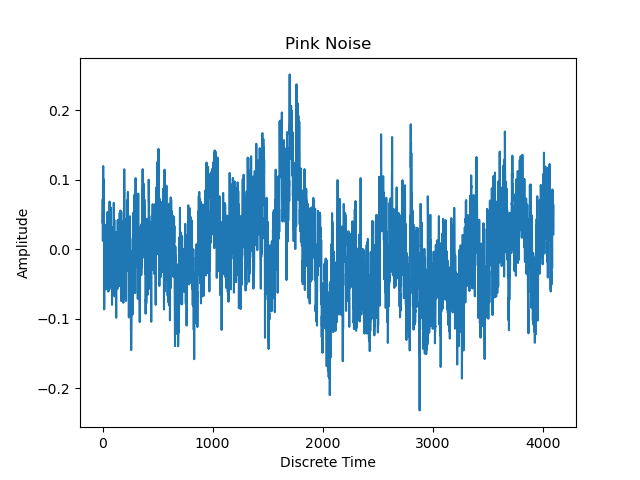

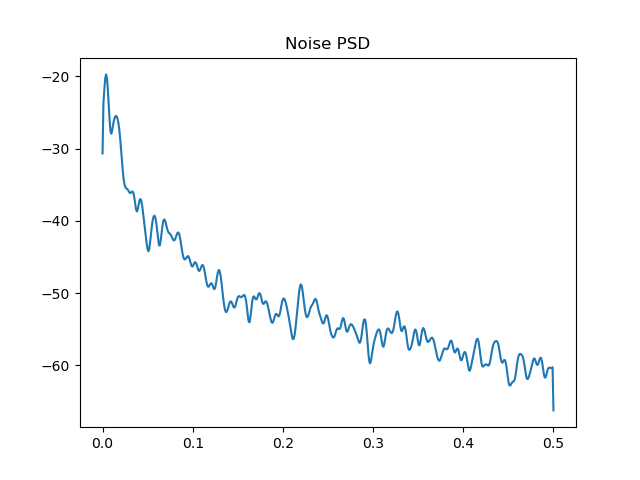

In [349]:
N_synth2 = 2**12-1

K_synth2 = 8

#f_synth2 = 0.48*np.random.rand(0,K_synth2) + 0.1*np.ones(K_synth2) 

#a_synth2 = 19*np.random.rand(0,K_synth2) + np.ones(K_synth2) 

f_synth2 = 0.05*np.arange(1,K_synth2+1)

a_synth2 = np.array([18, 15, 13, 11, 8, 5, 4, 3])

delta_synth2 = -0.002*np.ones([K_synth2])

phi_synth2 = np.array([0, 1.5, 0, 1, 0, 1.5, 0, 1])

# synthesised signal
x_synth2 = pam.synthesize(N_synth2, delta_synth2, f_synth2, a_synth2, phi_synth2, 0, 0, 2, 70)

print("SNR =", x_synth2[3], "dB")

plt.figure()
plt.plot(np.real(x_synth2[0]))
plt.title('Noisy Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(np.real(x_synth2[1]))
plt.title('Sinusoidal Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(x_synth2[2])
plt.title('Pink Noise')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
plt.show()


plt.figure()
plt.title("Noise PSD")
freq_synth2, PSD_noise_synth2 = signal.welch(x_synth2[2], nfft=1024)
plt.plot(freq_synth2, 20*np.log10(PSD_noise_synth2))
plt.show()


In [350]:
# play signal 
fs_synth2 = 1000

sd.play(np.real(x_synth2[0]), fs_synth2)

print("The length of the signal is", N_synth2/fs_synth2, "seconds.")

t = np.linspace(0., N_synth2/fs_synth2, fs_synth2)
amplitude = 0.01*np.iinfo(np.int16).max
data  = amplitude*np.real(x_synth2[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("noisy2.wav", fs_synth2, data.astype(np.int16))

The length of the signal is 4.095 seconds.


> ## Loading Experimental Data

C:\Users\royal\anaconda3\envs\env_pam_hr\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 512 is greater than input length  = 80, using nperseg = 80
  warnings.warn('nperseg = {0:d} is greater than input length '


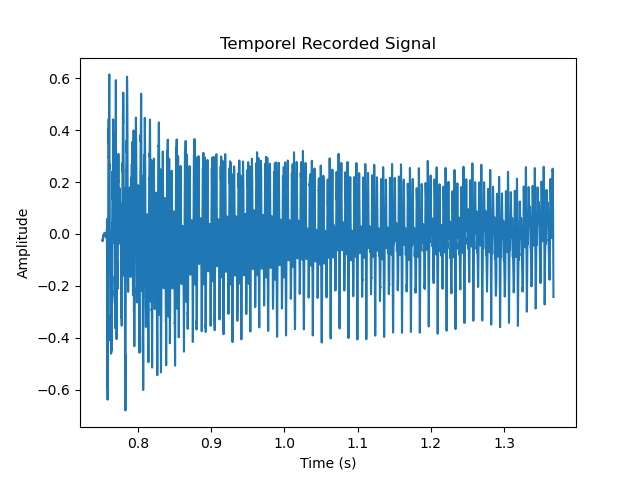

The length of the signal is 0.6152148437499999 seconds.


In [506]:
# Loading config from config files
conf_dir = pathlib.Path('./config/expr/')
data_dir = pathlib.Path('../data/expr/2022_01_27')
#
log_path = conf_dir / 'log_config.json'
conf_path = conf_dir / 'analysis_config.json'
data_path = data_dir / 'FirstStringGuitar_CopperWired005mm_5cmFromBridge_1.mat'

log = load_data_json(log_path)
conf = load_data_json(conf_path)
expr_data = load_analysis(data_path, conf)

# see expr/util.py for details on what's inside expr_data
mic = expr_data["temporal"]["mic"]["whole"][38500:70000]
times = expr_data["times"]["whole"][38500:70000]

plt.figure()
plt.title("Temporel Recorded Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(times, mic)
plt.show()

print("The length of the signal is", times[-1]-times[0], "seconds.")

In [507]:
# play signal
fs_mic = int(1/(times[1]-times[0]))

sd.play(mic, fs_mic)


t = np.linspace(0., N_vibr0/fs_mic, fs_mic)
amplitude = np.iinfo(np.int16).max
data  = 0.1*amplitude*np.real(mic)

# UNCOMMENT TO WRITE A NEW WAV FILE
write("acc.wav", fs_mic, data.astype(np.int16))

In [508]:
9fft = np.fft.fft(band[35000:])
freqs = np.fft.fftfreq(mic[35000:].size)
plt.figure()
plt.plot(freqs*fs_mic, np.abs(fft))
plt.title('Periodogram')
plt.show()

NameError: name 'band' is not defined

(20000,)

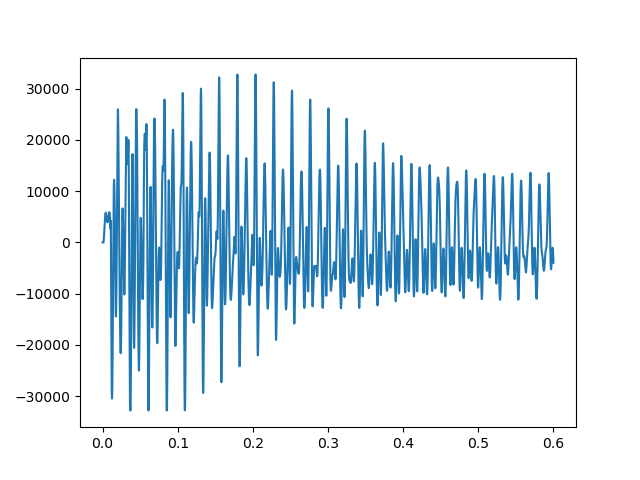

In [652]:
#uk_dir = 'C:\Users\royal\Desktop\HP\PAM\atiam_pam_hrparam\data\synth_uk\'
#file_name = pjoin(uk_dir, 'lowE_uk.wav')

file_name = r'C:\Users\royal\Desktop\HP\PAM\atiam_pam_hrparam\data\synth_uk\lowE_uk.wav'

fs_uk, synth_uk = read(file_name)

length_uk = synth_uk.shape[0] / fs_uk

times_uk = np.linspace(0., length_uk, synth_uk.shape[0])

plt.figure()

plt.plot(times_uk, synth_uk)

synth_uk.shape


In [572]:
# play signal

sd.play(synth_uk, fs_uk)


In [ ]:
data_dir = pjoin(dirname(scipy.io.__file__), 'tests', 'data')
wav_fname = pjoin(data_dir, 'test-44100Hz-2ch-32bit-float-be.wav')
Load the .wav file contents.

samplerate, data = wavfile.read(wav_fname)
print(f"number of channels = {data.shape[1]}")
number of channels = 2
length = data.shape[0] / samplerate
print(f"length = {length}s")
length = 0.01s
Plot the waveform.

import matplotlib.pyplot as plt
import numpy as np
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


> ## Signal Treatment

> Constructing the Filter Bank

In [633]:
fs_mic
fs_uk

33333

10


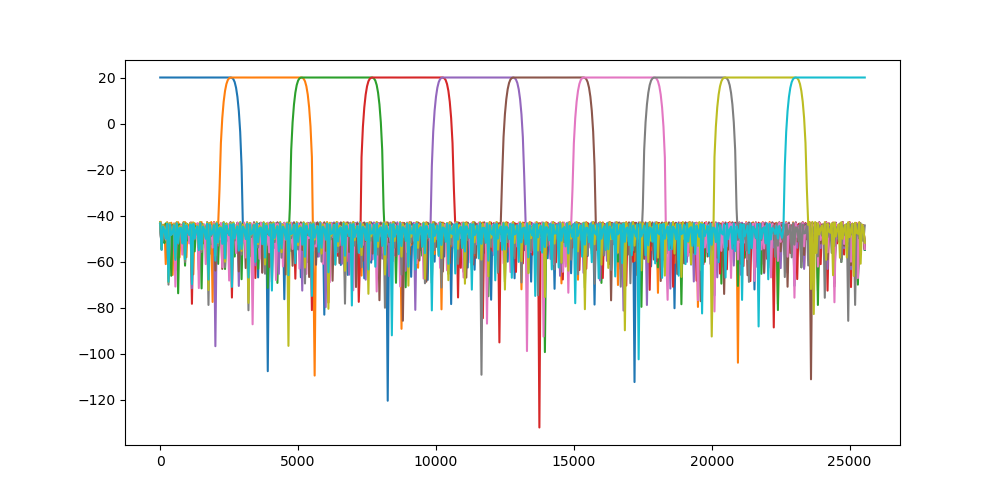

In [630]:
bank_coeffs = pam.filter_bank(10, fs_mic, 425, 425)

print(len(bank_coeffs))

plt.figure(figsize=[10,5])

for i in range(len(bank_coeffs)):
    
    freqs, amps = signal.freqz(bank_coeffs[i], [1])
    plt.plot(0.5*fs_mic*freqs/np.pi, 20*np.log10(np.abs(amps)))
    

plt.show()

6


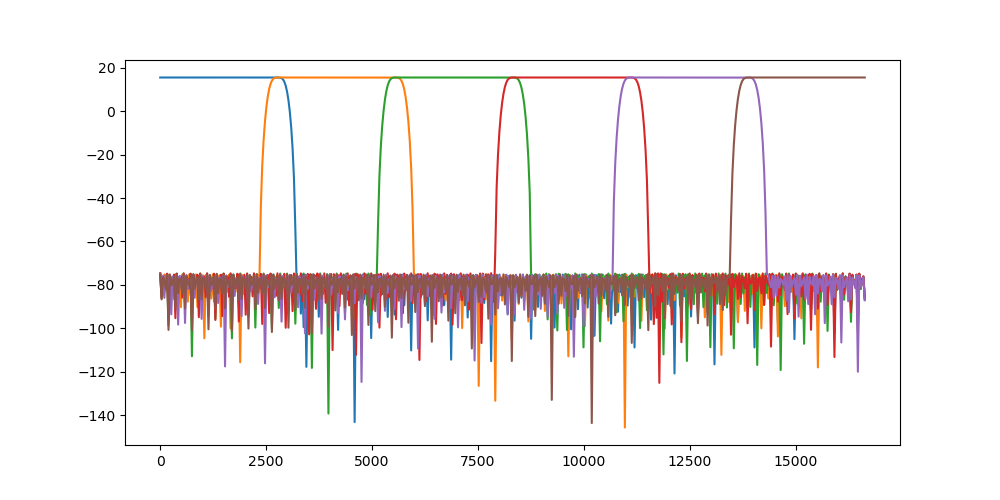

In [631]:
bank_coeffs_uk = pam.filter_bank(6, fs_uk, 425, 425)

print(len(bank_coeffs_uk))

plt.figure(figsize=[10,5])

for i in range(len(bank_coeffs_uk)):
    
    freqs, amps = signal.freqz(bank_coeffs_uk[i], [1])
    plt.plot(0.5*fs_uk*freqs/np.pi, 20*np.log10(np.abs(amps)))
    

plt.show()

> Filtering Signal with the Filter Bank and Decimation

In [510]:
num_bands = len(bank_coeffs)
mic_bands = []

for i in range(num_bands):
    filtered = signal.lfilter(bank_coeffs[i], [1], mic)
    decimated = pam.decimate(filtered, num_bands)
    mic_bands.append(decimated)
    

In [656]:
mic_bands[0].shape

(3150,)

In [657]:
# Filtering UK
num_bands_uk = len(bank_coeffs_uk)
uk_bands = []

for i in range(num_bands_uk):
    filtered = signal.lfilter(bank_coeffs_uk[i], [1], synth_uk)
    decimated = pam.decimate(filtered, num_bands_uk)
    uk_bands.append(decimated)

fs_bands_uk = fs_uk//num_bands_uk

> PSD of Signal by Sub-bands

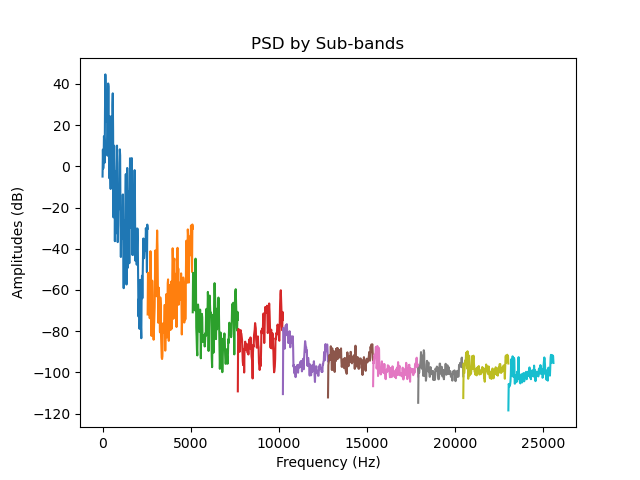

In [511]:
fs_bands = fs_mic//num_bands
plt.figure()
for i in range(num_bands):
    
    freqs, PSD = signal.welch(mic_bands[i])
    plt.plot(fs_bands*freqs+i*fs_bands/2, 20*np.log10(PSD))
    plt.title('PSD by Sub-bands')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitudes (dB)')

    #freqso, amps = signal.freqz(bank_coeffs[i], [1])
    #plt.plot(0.5*fs_mic*freqso/np.pi, 20*np.log10(np.abs(amps)))
plt.show()

#for i in range(num_bands):    
#    fft = np.fft.fft(mic_bands[i])
#    freqs = np.fft.fftfreq(mic_bands[i].size)
#    plt.figure()
#    plt.plot(freqs*fs_bands, np.abs(fft))
#    plt.show()

In [512]:
# play one sub-band
sd.play(mic_bands[0], fs_bands)

> #### Noise Whitening

> Testing with Synthetic Signal

[0.00358852 0.00237742 0.00138169 ... 0.00101626 0.00138169 0.00237742]
The minimum value for the smoothing order is 131.136


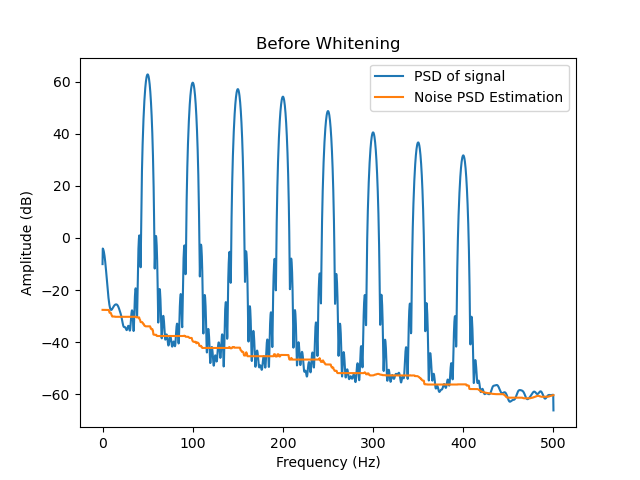

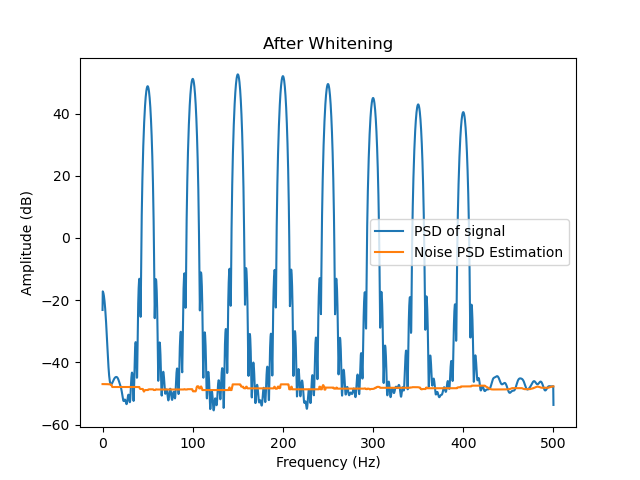

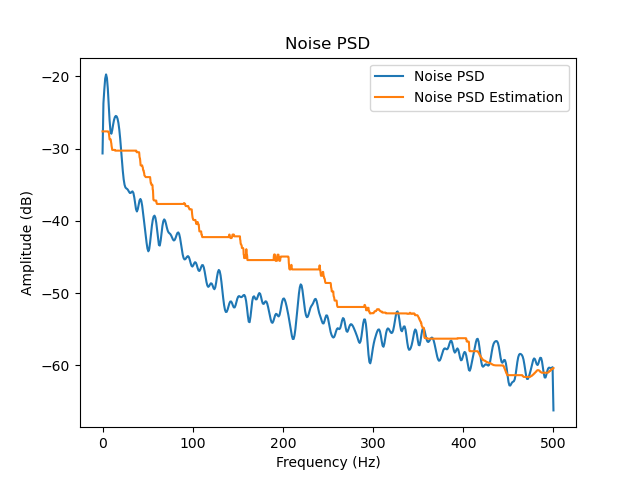

In [513]:
x_white2, freq2_norm, PSD_x2, PSD_noise2, PSD_x_white2, PSD_noise_white2 = pam.whiten(np.real(x_synth2[0]), 200, 4, 15)

print('The minimum value for the smoothing order is', 4*0.016*len(freq2_norm))

freq2 = fs_synth2*freq2_norm

plt.figure()
plt.title('Before Whitening')
plt.plot(freq2, 20*np.log10((PSD_x2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

plt.figure()
plt.title('After Whitening')
plt.plot(freq2, 20*np.log10((PSD_x_white2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise_white2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()


plt.figure()
plt.title("Noise PSD")
plt.plot(fs_synth2*freq_synth2, 20*np.log10(PSD_noise_synth2), label = 'Noise PSD')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

> Whitening the Experimental Signal (before filter bank)

[4.82725784e-06 3.89927491e-06 2.93266479e-06 ... 1.87629918e-06
 2.93266479e-06 3.89927491e-06]
The smoothing order must be at least 1048.64


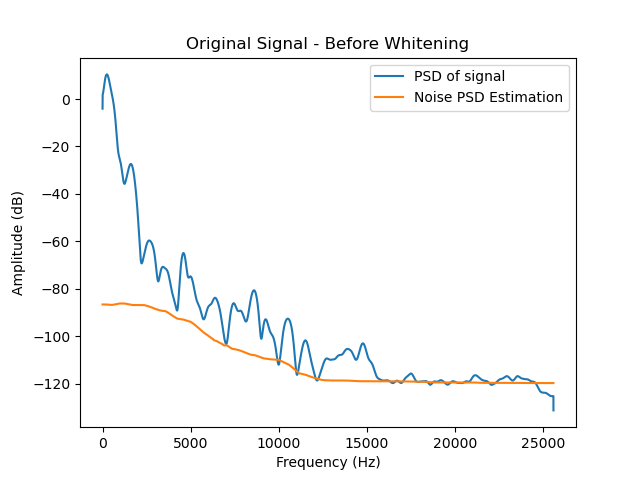

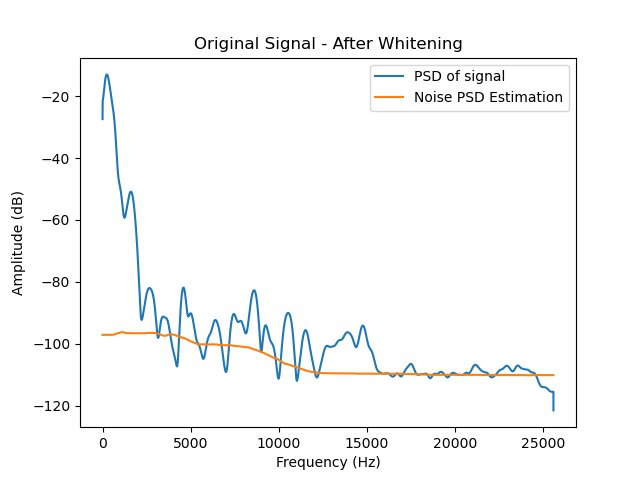

In [514]:
mic_white, freq_mic, PSD_mic, PSD_noise_mic, PSD_mic_white, PSD_noise_mic_white = pam.whiten(mic, 10000, 4, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_mic))

freq_mic *= fs_mic

plt.figure()
plt.title('Original Signal - Before Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,500)
plt.legend()
plt.show()

plt.figure()
plt.title('Original Signal - After Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic_white)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()

> Whitening the First Band

[0.06753954 0.06009717 0.04688855 ... 0.03480838 0.04688855 0.06009717]
The smoothing order must be at least 131.136


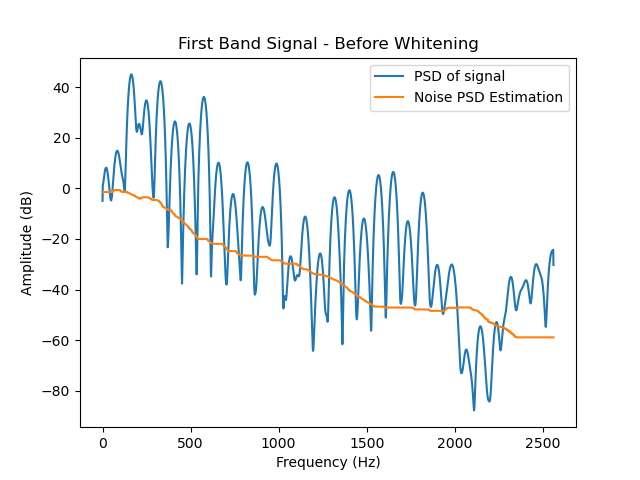

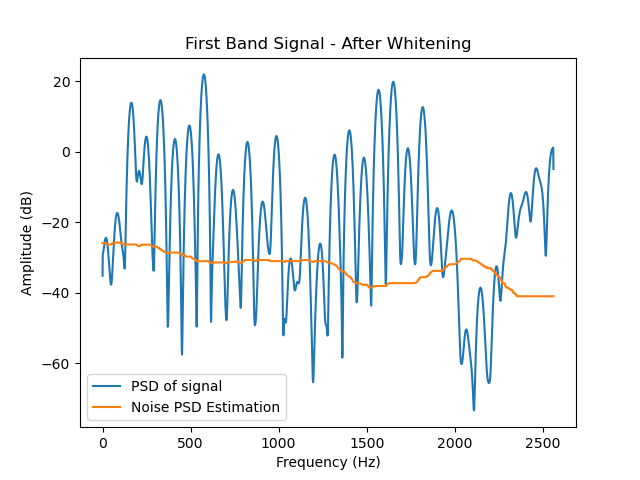

In [597]:
band0_white, freq_band0, PSD_band0, PSD_noise_band0, PSD_band0_white, PSD_noise_band0_white = pam.whiten(mic_bands[0], 1200, 4, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_band0))

freq_band0 *= fs_bands

plt.figure()
plt.title('First Band Signal - Before Whitening')
plt.plot(freq_band0, 20*np.log10((PSD_band0)), label = 'PSD of signal')
plt.plot(freq_band0, 20*np.log10((PSD_noise_band0)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,500)
plt.legend()
plt.show()

plt.figure()
plt.title('First Band Signal - After Whitening')
plt.plot(freq_band0, 20*np.log10((PSD_band0_white)), label = 'PSD of signal')
plt.plot(freq_band0, 20*np.log10((PSD_noise_band0_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()

> ## HR Analysis

> Testing EPRIT and LeastSquares

In [598]:
delta_an, f_an = pam.esprit(x_synth[0], 32, 2)

alpha_an, a_an, phi_an = pam.least_squares(x_synth[0], delta_an, f_an)

#EdB_an = Energy(x_synth, delta_an, a_an)

print(delta_an, f_an, alpha_an, a_an, phi_an)#, EdB_an)


[-5.00000000e-02 -1.11022302e-16] [0.26587302 0.25      ] [8.77582562+4.79425539j 0.0707372 +0.99749499j] [10.  1.] [0.5 1.5]


> Testing ESPRIT by Blocks (with a vibrato)

In [599]:
delta00, f00, alpha00, a00, phi00 = pam.esprit_blocks(vibrato0[0][:200], 0.035, 0.020, fs_vibr0, 32, 1)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr0, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

- Damping factors:
 [[-0.06462156]
 [-0.1059914 ]
 [-0.07731631]
 [-0.04093937]
 [-0.03264625]
 [-0.06462156]
 [-0.1059914 ]
 [-0.07731631]] 
- Frequencies:
 [[263.86192528]
 [295.01165819]
 [340.46558463]
 [251.49205179]
 [348.0143032 ]
 [263.86192528]
 [295.01165819]
 [340.46558463]] 
- Complex Amplitudes:
 [[ 0.48384274+0.86758021j]
 [-0.77708497+0.96585895j]
 [-0.39036651+0.70820166j]
 [ 0.70678423-1.15950977j]
 [ 0.6792423 +0.05645188j]
 [ 0.48384274+0.86758021j]
 [-0.77708497+0.96585895j]
 [-0.39036651+0.70820166j]] 
- Amplitudes:
 [[0.99337768]
 [1.23965502]
 [0.80866285]
 [1.35794214]
 [0.68158413]
 [0.99337768]
 [1.23965502]
 [0.80866285]] 
- Intial Phases:
 [[ 1.06206657]
 [ 2.24830748]
 [ 2.0745666 ]
 [-1.02338117]
 [ 0.08291951]
 [ 1.06206657]
 [ 2.24830748]
 [ 2.0745666 ]]


In [600]:
delta00, f00, alpha00, a00, phi00 = pam.esprit_blocks(vibrato1[0][:200], 0.035, 0.020, fs_vibr1, 32, 8)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr1, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

- Damping factors:
 [[-3.99018504e-04 -5.11648777e-02 -1.61751412e-02 -2.17501812e-02
  -7.54332065e-01 -8.41152895e-01 -1.08477983e+00 -1.82022624e+00]
 [ 1.21470909e-02 -3.96442359e-02 -1.60432506e-02 -1.97426855e-02
  -7.35685462e-01 -1.74720209e+00 -1.41502300e+00 -2.40817100e+00]
 [ 5.58152995e-03 -8.04081747e-02 -2.52476794e-02 -2.28152058e-02
  -8.45324551e-01 -7.42156642e-01 -2.82816785e+00 -1.68001254e+00]
 [-3.07484531e-03 -3.53812549e-02 -7.49039517e-02 -3.59170767e-02
  -1.20906903e+00 -1.35392426e+00 -1.89337071e+00 -7.91891300e-01]
 [-5.48615248e-03 -1.25277212e-02 -9.01560465e-02 -2.36382994e-02
  -9.65432597e-01 -2.36478231e+00 -9.33613192e-01 -1.33199370e+00]
 [ 6.35433197e-03 -7.34790937e-02 -1.05477074e-02 -3.52732370e-02
  -1.02956838e+00 -8.64977946e-01 -8.67807475e-01 -2.25946021e+00]
 [ 1.23748675e-02 -2.79354065e-02 -1.44761264e-02 -2.35980917e-02
  -8.63931708e-01 -2.18030731e+00 -1.12774504e+00 -1.95715011e+00]
 [-7.29828026e-04 -6.53989010e-02 -2.08824490e-02

> HR Analysis for Experimental Signal

In [601]:
delta_mic, f_mic, alpha_mic, a_mic, phi_mic = pam.esprit_blocks(mic_white, 0.030, 0.020, fs_mic, 32, 30)

print( 'Frequencies:\n', f_mic*fs_mic, '\n\n- Damping factors:\n', delta_mic, '\n\n- Complex Amplitudes:\n', alpha_mic, '\n\n- Amplitudes:\n', a_mic, '\n\n- Intial Phases:\n', phi_mic )

Frequencies:
 [[     0.            701.33965876   -701.33965876   2219.51673767
   -2219.51673767   4428.48327129  -4428.48327129   5839.27927617
   -5839.27927617   7578.03254171  -7578.03254171   8818.90389097
   -8818.90389097  10565.88957189 -10565.88957189  23853.16291199
  -23853.16291199  25600.          20980.08710092 -20980.08710092
   12127.8971968  -12127.8971968   18481.43328062 -18481.43328062
   17117.12006925 -17117.12006925  13720.89625649 -13720.89625649
   14837.99426308 -14837.99426308]
 [ 23138.62540194 -23138.62540194  21713.46355845 -21713.46355845
   20363.31047048 -20363.31047048  18205.73389854 -18205.73389854
   16444.02941619 -16444.02941619  15017.29499828 -15017.29499828
   13078.66637171 -13078.66637171  11669.98460205 -11669.98460205
    8668.91627662  -8668.91627662    290.86996149   -290.86996149
    1428.45676657  -1428.45676657   2671.71727816  -2671.71727816
    4348.60227881  -4348.60227881   5537.67216043  -5537.67216043
    6778.38775941  -6778.38

In [661]:
# ESPRIT FOR synth_uk
window_length = 0.05
hop_size = 0.05

delta_uk, freq_uk, alpha_uk, amp_uk, phi_uk = pam.esprit_blocks(uk_bands[0], window_length, hop_size, fs_bands_uk, 64, 62)

freq_uk_hz = freq_uk*fs_bands_uk

print(freq_uk_hz.shape)

print( 'Frequencies:\n', freq_uk_hz) #, '\n\n- Damping factors:\n', delta_band0, '\n\n- Complex Amplitudes:\n', alpha_band0, '\n\n- Amplitudes:\n', amp_band0, '\n\n- Intial Phases:\n', phi_band0 )

(11, 62)
Frequencies:
 [[ 2426.6506198  -2426.6506198   2599.93434381 -2599.93434381
   2777.5         2276.21719536 -2276.21719536  2706.62600841
  -2706.62600841  2115.38627437 -2115.38627437  2195.33645251
  -2195.33645251  1942.99345583 -1942.99345583  2007.41119074
  -2007.41119074  1849.46932882 -1849.46932882  1711.81509295
  -1711.81509295  1725.40682845 -1725.40682845  1551.92662775
  -1551.92662775  1517.9809591  -1517.9809591   1392.57408709
  -1392.57408709  1239.00565988 -1239.00565988  1313.0184596
  -1313.0184596   1081.59538879 -1081.59538879  1109.15802978
  -1109.15802978   942.68775144  -942.68775144   895.70630524
   -895.70630524   765.71959302  -765.71959302   678.61546642
   -678.61546642   604.92404822  -604.92404822   514.50378742
   -514.50378742   450.71282075  -450.71282075   312.80482545
   -312.80482545    86.78261454   -86.78261454   213.50496615
   -213.50496615   185.97241303  -185.97241303    64.53175625
    -64.53175625     0.        ]
 [ 2777.5      

In [662]:
band0_white_n = 128

band0_white_order_pmax = band0_white_n//2

band0_white_order = pierre.Ester.estimate_esm_ordre(band0_white, band0_white_n, band0_white_order_pmax)

band0_white_order

38

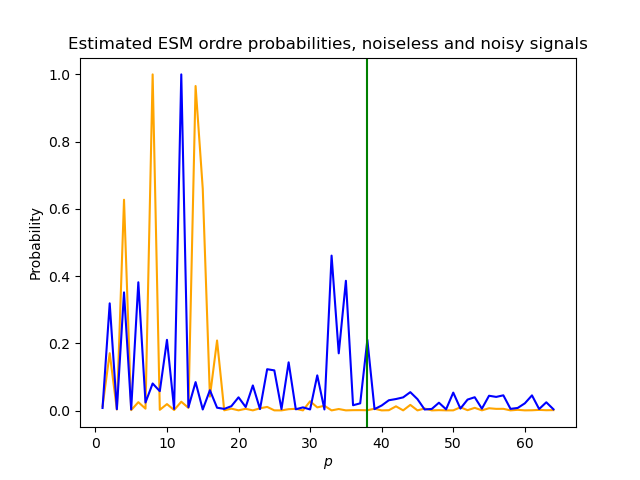

Ordre of the ESM model
Truth=38
 Noisy=17, Whitened=38


In [663]:
ps = np.arange(1,band0_white_order_pmax+1)
#j_sine = Ester.inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = pierre.Ester.inverse_error_func(mic_bands[0], n=band0_white_n, p_max=band0_white_order_pmax)
j_white = pierre.Ester.inverse_error_func(band0_white, n=band0_white_n, p_max=band0_white_order_pmax)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
#plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(band0_white_order, ymin=0, ymax=1, c='g')
plt.show()

#r_est_sine = Ester.estimate_esm_ordre(x_sine, n_est, p_max)
r_est_noise = pierre.Ester.estimate_esm_ordre(mic_bands[0], n=band0_white_n, p_max=band0_white_order_pmax)
r_est_white = pierre.Ester.estimate_esm_ordre(band0_white, n=band0_white_n, p_max=band0_white_order_pmax)
print('Ordre of the ESM model')
print(f'Truth={band0_white_order}')
print(f' Noisy={r_est_noise}, Whitened={r_est_white}')

In [664]:
window_length = 0.05
hop_size = 0.05

delta_band0, freq_band0, alpha_band0, amp_band0, phi_band0 = pam.esprit_blocks(band0_white, window_length, hop_size, fs_bands, 64, 62)

freq_band0_hz = freq_band0*fs_bands
print(freq_band0_hz.shape)

print( 'Frequencies:\n', freq_band0_hz) #, '\n\n- Damping factors:\n', delta_band0, '\n\n- Complex Amplitudes:\n', alpha_band0, '\n\n- Amplitudes:\n', amp_band0, '\n\n- Intial Phases:\n', phi_band0 )

(11, 62)
Frequencies:
 [[ 2560.          2473.8166161  -2473.8166161   2416.19547128
  -2416.19547128  2337.47160394 -2337.47160394  2285.96069453
  -2285.96069453  2139.76754719 -2139.76754719  1982.70897031
  -1982.70897031  1902.63504085 -1902.63504085  1822.57551254
  -1822.57551254  1739.0768294  -1739.0768294   1652.47680136
  -1652.47680136  1566.54032856 -1566.54032856  1579.2327276
  -1579.2327276   1476.840354   -1476.840354    1396.57010547
  -1396.57010547  1315.06619029 -1315.06619029  1224.8170684
  -1224.8170684   1133.80533146 -1133.80533146     0.
    142.24255879  -142.24255879   186.1655849   -186.1655849
    237.36086516  -237.36086516   322.51126143  -322.51126143
    407.18538246  -407.18538246   493.31306214  -493.31306214
    576.32001231  -576.32001231   659.20704529  -659.20704529
    744.28019878  -744.28019878   822.05913218  -822.05913218
    919.7239963   -919.7239963    975.78159176  -975.78159176
   1036.34911106 -1036.34911106]
 [ 2545.16856893 -2545.16

[  15.70611635   82.00453803  164.03136288  244.9576309   328.82385201
  410.93350527  493.13868829  575.10969023  657.37403388  739.86620257
  822.47131731  904.69964715  987.02141554 1069.52925717 1152.83358209
 1234.16072314 1318.14501988 1400.87446978 1484.11770068 1567.12493064
 1650.04654018 1732.54142456 1816.86101596 1898.3215132  1975.32741814
 2106.08795738 2239.6348517  2326.56779966 2412.93823419 2489.09643163
 2560.         2560.        ]
[   0.           78.59610153   95.28487408  161.80230782  206.13968926
  249.92349652  336.5950432   367.45057003  489.96410624  548.75601421
  626.13215089  725.49689345  889.31361927 1011.7227644  1096.55734049
 1192.35828266 1300.74702989 1454.00704674 1609.13290349 1680.28554372
 1760.30947474 1823.08859471 1977.75786965 2092.56581212 2214.33388133
 2280.12975881 2375.33758129 2463.46233205 2529.8591181  2644.00438821
 2723.66342771 2777.5       ]


C:\Users\royal\AppData\Local\Temp\ipykernel_26596\518675546.py:33: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x_uk[:-3], y_uk[:-3], 'g', markerfmt='Dg',  label='HR (UK synthesis)')


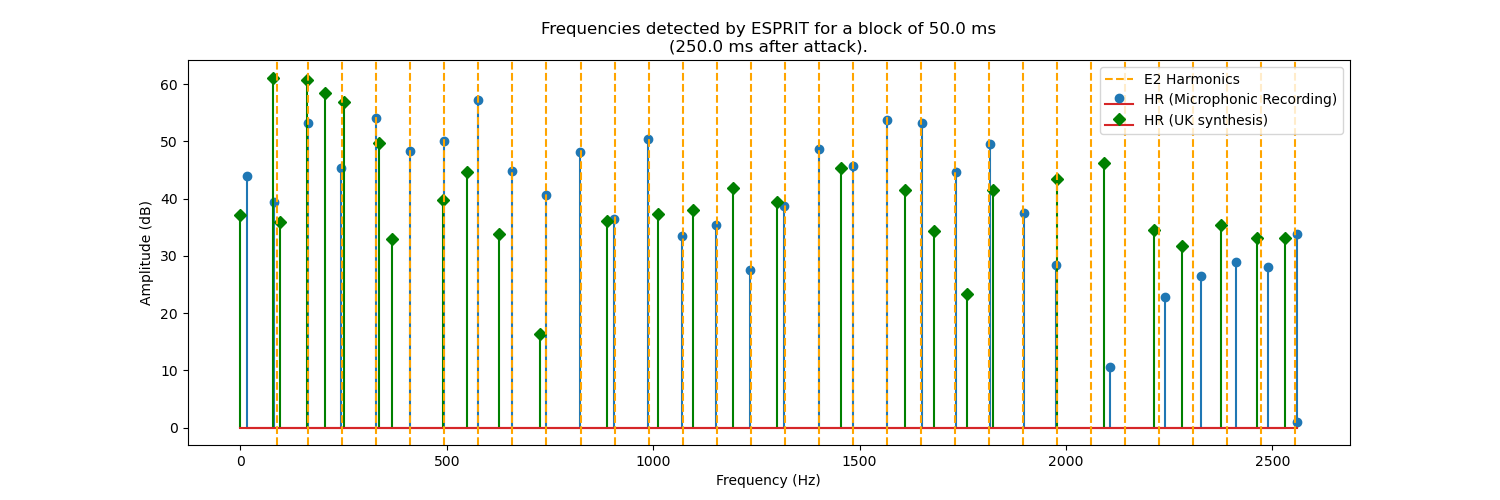

In [681]:
block = 5

graph = np.array([freq_band0_hz[block], amp_band0[block]])

graph = graph[:, graph[0, :].argsort()]

start = freq_band0_hz.shape[1]//2 - 1

x = graph[0][start:]
y = np.abs(np.min(20*np.log10(graph[1][start:]))) + 20*np.log10(graph[1][start:]) + 1

graph_uk = np.array([freq_uk_hz[block], amp_uk[block]])

graph_uk = graph_uk[:, graph_uk[0, :].argsort()]

start_uk = freq_uk_hz.shape[1]//2 - 1

x_uk = graph_uk[0][start_uk:]
y_uk = np.abs(np.min(20*np.log10(graph_uk[1][start_uk:]))) + 20*np.log10(graph_uk[1][start_uk:]) + 1
y_uk = 0.4*y_uk

print(x)
print(x_uk)

plt.figure(figsize = [15,5])

plt.title('Frequencies detected by ESPRIT for a block of ' + str(window_length*1000) + ' ms\n(' + str(block*hop_size*1000) + ' ms after attack).')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')

plt.stem(x, y, label='HR (Microphonic Recording)')

plt.stem(x_uk[:-3], y_uk[:-3], 'g', markerfmt='Dg',  label='HR (UK synthesis)')


plt.axvline(88.4, 0, 1, color='orange', linestyle='dashed', label='E2 Harmonics')
for i in range(2,32):
    plt.axvline(i*82.4, 0, 1, color='orange', linestyle='dashed')

plt.legend(loc = 'upper right')
plt.show()

In [505]:
mato = np.array([[9,4], [3, 8]])
mato

array([[9, 4],
       [3, 8]])

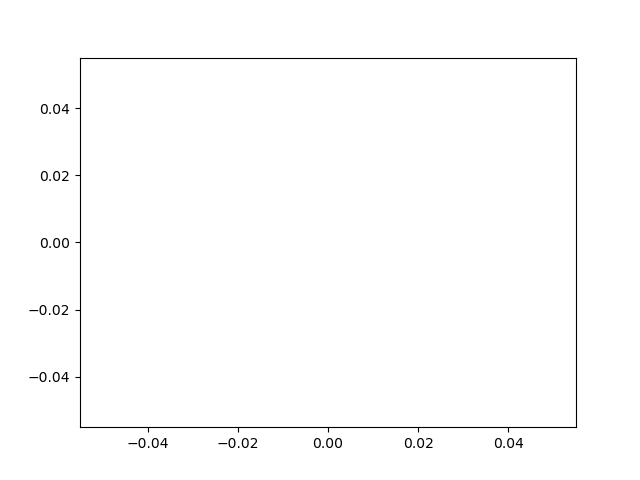

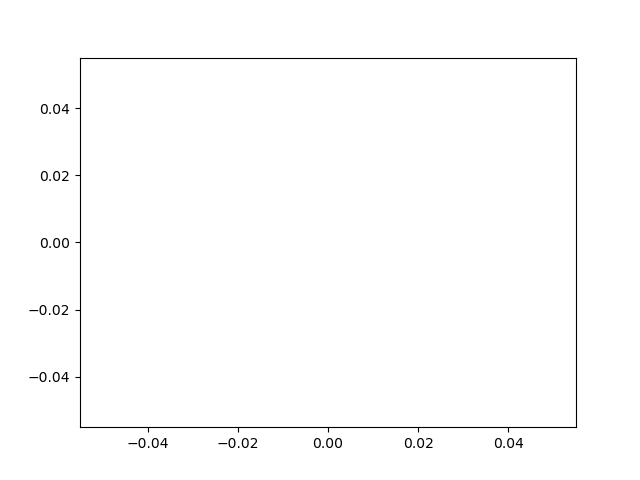

In [473]:
mic_pre, freq_pre, PSD_mic, PSD_mic_pre = pam.preemphasize(mic[35000:70000])

plt.figure()
plt.plot(freq_pre, 20*np.log10((PSD_mic)), label = 'PSD of signal')
plt.show()

plt.figure()
plt.plot(freq_pre, 20*np.log10((PSD_mic_pre)), label = 'PSD of signal')
plt.show()

In [474]:
print('sss' + str(9))

sss9


In [475]:
def Adaptive(x : np.ndarray, n : int, r : float, fe : float, beta: float):
    # n : number of lines in W
    # r : estimation by ESTER of the order
    # # n>r
    # fe: sampling frequency
    #  0 < β < 1 is the forgetting factor

    # computation of W(0), Z(0)
    W0 = np.zeros(n, r)
    W0[:r, :] = np.identity(r)
    W0[r:, :] = 0
    Z0 = np.identity(r)
    
    # time step
    NbEch = len(x)
    t = (np.arange(0, NbEch)/fe)
    W = []
    W.append(W0)
    # W = np.zeros((1, t))
    # W[0] = W0
    

    Z = []
    Z.append(Z0)
    #Z = np.zeros((1, t))
    #Z[0] = Z0

    psi = []
    Phi = []    # the list of Φ(t) 
    eigenvalues = []

    #e = np.zeros((1, t))   #e(t) , not sure about the dimension
    phi = np.zeros((1, t)) #Θ(t) , not sure about the dimension
    #e_point = np.zeros((1, t)) #e'(t) , not sure about the dimension

    #matrix dimensions : y(t), h(t), g(t)
    #y = np.zeros((n, r))
    #h = np.zeros((r, r))
    #g = np.zeros((2, r))
  
    for i in t:  #from 0 to t-1
        # PAST main section
        y = W[i].conj().T @ x[i+1]
        h = Z[i] @ y
        g = h / (beta + y.conj().T @ h)

        # API main section
        e = x[i+1] - W[i]@y #e(t)
        phi = (np.identity(r) + np.linalg.norm(e)**2 @ g @g.conj().T)**(-1/2)
        Z[i+1] = 1/beta * phi.conj().T @ (np.identity(r) - g @ y.conj().T)@Z[i] @ np.linalg.inv(phi.conj().T)
        W[i+1] = (W[i] + e[i+1] @ g.conj().T) @ phi[i+1]

        # FAPI main section (constants)
        sigma_sqaure = np.linalg.norm(x[i+1])**2 - np.linalg.norm(y)**2
        tho = sigma_sqaure/ (1 + sigma_sqaure*np.linalg.norm(g)**2 + np.sqrt(1 + sigma_sqaure*np.linalg.norm(g)**2))
        nu = 1 - tho*np.linalg.norm(g)**2

        #vectors
        y_point = nu*y + tho*g
        h_point = Z[i].conj().T @ y_point
        big_sigma = tho/nu * (Z[i]@g - (h_point.conj().T @ g)@ g)
        Z[i+1] = 1/beta * (Z[i] - g @ h_point.conj().T + big_sigma @ g.conj().T) 
        e_point = nu*x[i+1] - W[i] @ y_point
        # update rules
        W[i+1] = W[i] + e_point[i+1] @ g.conj().T
        
        W.append(W[i+1])
        Z.append(Z[i+1])

        #Adaptive computation of the spectral matrix
        W_down = W[i][0:-1, :]
        W_up = W[i][1:, :]
        e_minus = W_down.conj().T @ e_point[1:, ]
        e_plus = W_up.conj().T @ e_point[0:-1, :]
        epoint_plus = e_plus + g @ (e_point[1:, ].conj().T @ e_point[0:-1, :])
        psi = W_down.conj().T @ W_up  #psi[i]

        psi.append(psi)
        psi = psi + e_minus @ g.conj().T  + g @ epoint_plus.conj().T #psi[i+1], update rules for Ψ(t)

        nu = W[i+1][-1, :]            #last row of W(t),
        phi_phi = psi.conj().T @ nu   # ϕ(t)
        big_phi = psi + 1/(1 - np.linalg.norm(nu)**2) * nu @ phi_phi.conj().T  # Φ(t)
        
        Phi.append(big_phi)
        
        D = scipy.linalg.eig(big_phi, left = False, right = False)    # D, eigenvalues of big_phi
        eigenvalues.append(D) 
        # eigenvalues tracking


        
        ### Adaptive computation of the spectral matrix
        return W, eigenvalues  # W is the list [W0 W1 W2 W3......], D is the list of eigenvalue

In [450]:
# Another code for filter bank and decimation (incomplete)

center_freqs = np.arange(100, 3000, 100) # à nous de définir selon le signal
def filter_bank0(sig : np.ndarray, center_freqs : np.ndarray, fe : float):
    #input
       #sig
       #center_freqs : centered frequencies in filter banks
       #fe : sampling frequency


    #filter banks
    #PSD_sig = plt.psd(sig)
    nb_bands = len(center_freqs)
    #crossover_gain = 10**(-3/20) # cross at -3db of gain for the adjacent bands

    #band edges, frequencies
    band_edges = np.zeros((nb_bands,2))
    #band_edges [:,0] = center_freqs -  
    #band_edges [:,1] = center_freqs +   

    h = [] #impulse response 
    sig_list = []  #Roy: I suggest that we use an numpy array
    for i in range(nb_bands):
       b, a = signal.butter(nb_bands, [band_edges[i,0],band_edges[i,1]], btype = 'bandpass',analog=False, fs=fe,output='SOS')
       #w, H = signal.sosfreqz(h[i], worN=2000,fs=fe)  #Compute the frequency response of a digital filter in SOS format     
       sig_list.append(lfilter(b, a, sig))
   
    return sig_list